## WB2 - FFN

The feature extraction process is based on this [blog](http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/)

Some functions will be used that were previously defined in WB1

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
def load_files(file_paths, sr):
    waves = []
    for path in file_paths:
        X,sr = librosa.load(path, sr=sr)
        waves.append(X)
    return waves

As described in the blog post, we are about to do dimensionality reduction of audio using feature extraction methods provided by the Python library librosa. The feature extractions methods involved are:

- MFCC: representation of the short-term power spectrum of a sound
- Mel-frequency cepstral coefficients: Coefficients that collectively make up an mel-frequency cepstrum
- Chromagram of a short-time Fourier transform: Projects into bins representing the 12 distinct semitones of the musical octave
- Octave-based spectral contrast: Distribution of sound energy over octave frequencies 
- Tonnetz: Estimates tonal centroids features

Combining these 5 feature extractions will result in a vector of 193 values. Is important to remark that this vector will always have the same length even if the audio files are of different length. 

In [3]:
def extract_features(file_name):
    X, sr = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_file(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    return features

Now lets test the dimensionality reduction with a sample file

In [4]:
def run_sample(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    all_features = np.hstack((mfccs,chroma,mel,contrast,tonnetz))
    print "MFCSS  = ", len(mfccs)
    print "Chroma = ", len(chroma)
    print "Mel = ", len(mel)
    print "Contrast = ", len(contrast)
    print "Tonnetz = ", len(tonnetz)

    data_points, _ = librosa.load(filename)
    print "IN: Initial Data Points =", len(data_points)
    print "OUT: Total features =", len(all_features)

SAMPLE_FILE = os.path.join('data', 'physionet', 'training-a', 'a0001.wav')
run_sample(SAMPLE_FILE)

MFCSS  =  40
Chroma =  12
Mel =  128
Contrast =  7
Tonnetz =  6
IN: Initial Data Points = 786436
OUT: Total features = 193


As it can be observed the input sound file had a total of initial data points of 786436 and it was reduced to a vector of 193 features. Now lets do the same to the rest of the Physionet Cardiology Challenge 2016 dataset. This turns out to be a really long time process, it's adviced to load the precalculated files instead.

In [5]:
def parse_files(paths):
    
    save_path = os.path.join('data', 'physionet', 'reduced_features')
    encoder = LabelEncoder()
    for path, df_name in paths:
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['fname', 'target'])
        df['fname'] = df['fname'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['features'] = df['fname'].apply(parse_file)
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        feature_file = os.path.join(save_path, df_name + '_x.npy')
        label_file = os.path.join(save_path, df_name + '_y.npy')
        np.save(feature_file, np.array(df['features'].tolist()))
        np.save(label_file, np.array(df['target'].tolist()))
        
paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
         (os.path.join('data', 'physionet', 'training-b'), 'df_b'), 
         (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
         (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
         (os.path.join('data', 'physionet', 'training-e'), 'df_e')]

# Uncomment this line to parse audio files.
# This will take sometime.
#parse_files(paths)

In [6]:
npfiles = [('df_a_x.npy','df_a_y.npy'),
           ('df_b_x.npy','df_b_y.npy'),
           ('df_c_x.npy','df_c_y.npy'),
           ('df_d_x.npy','df_d_y.npy'),
           ('df_e_x.npy','df_e_y.npy')]

data_dir = os.path.join('data', 'physionet', 'reduced_features')

def load_npfiles(npfiles):
    concatenate = False
    for x, y in npfiles:
        print "Adding X:", x
        loaded_features = np.load(os.path.join(data_dir, x))
        print "Shape X:", loaded_features.shape

        print "Adding y:", y
        loaded_labels = np.load(os.path.join(data_dir, y))
        print "Shape Y:", loaded_labels.shape

        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

Adding X: df_a_x.npy
Shape X: (409, 193)
Adding y: df_a_y.npy
Shape Y: (409,)
Adding X: df_b_x.npy
Shape X: (490, 193)
Adding y: df_b_y.npy
Shape Y: (490,)
Adding X: df_c_x.npy
Shape X: (31, 193)
Adding y: df_c_y.npy
Shape Y: (31,)
Adding X: df_d_x.npy
Shape X: (55, 193)
Adding y: df_d_y.npy
Shape Y: (55,)
Adding X: df_e_x.npy
Shape X: (2141, 193)
Adding y: df_e_y.npy
Shape Y: (2141,)


### Training Neural Network

First we will split the dataset into training and testing.

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

The following code defines funcions to calculate precision, recall and fscore. A A simple neural network is implemented with one hidden layer. A dropout of .25 has been added to prevent overfitting. This means that 25% of a neurons activation output will be ignored, and not propagated.

In [8]:
from keras.models import Sequential
from keras import layers
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def create_model():
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (193,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, fbeta_score], callbacks=[checkpointer])
    return model

Now that everything is ready lets train a model and evaluate its results.

In [9]:
model = create_model()
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

/Users/lgovea/.virtualenvs/MLND/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 2344 samples, validate on 782 samples
Epoch 1/40
2344/2344 [==============================] - 0s - loss: 3.3206 - acc: 0.7760 - precision: 0.8043 - recall: 0.9544 - fbeta_score: 0.8703 - val_loss: 3.4250 - val_acc: 0.7852 - val_precision: 0.7852 - val_recall: 1.0000 - val_fbeta_score: 0.8775
Epoch 2/40
2344/2344 [==============================] - 0s - loss: 3.1488 - acc: 0.7986 - precision: 0.8039 - recall: 0.9919 - fbeta_score: 0.8862 - val_loss: 3.4250 - val_acc: 0.7852 - val_precision: 0.7852 - val_recall: 1.0000 - val_fbeta_score: 0.8775
Epoch 3/40
2344/2344 [==============================] - 0s - loss: 3.1326 - acc: 0.7999 - precision: 0.8043 - recall: 0.9920 - fbeta_score: 0.8865 - val_loss: 3.4250 - val_acc: 0.7852 - val_precision: 0.7852 - val_recall: 1.0000 - val_fbeta_score: 0.8775
Epoch 4/40
2344/2344 [==============================] - 0s - loss: 3.1400 - acc: 0.7965 - precision: 0.8030 - recall: 0.9894 - fbeta_score: 0.8851 - val_loss: 3.4250 - val_acc: 0.7852 - va

2344/2344 [==============================] - 0s - loss: 0.2242 - acc: 0.9091 - precision: 0.9257 - recall: 0.9648 - fbeta_score: 0.9436 - val_loss: 0.2300 - val_acc: 0.9054 - val_precision: 0.9229 - val_recall: 0.9600 - val_fbeta_score: 0.9400
Epoch 33/40
2344/2344 [==============================] - 0s - loss: 0.2193 - acc: 0.9078 - precision: 0.9289 - recall: 0.9595 - fbeta_score: 0.9427 - val_loss: 0.2380 - val_acc: 0.9066 - val_precision: 0.9229 - val_recall: 0.9611 - val_fbeta_score: 0.9408
Epoch 34/40
2344/2344 [==============================] - 0s - loss: 0.2271 - acc: 0.9061 - precision: 0.9289 - recall: 0.9555 - fbeta_score: 0.9411 - val_loss: 0.2322 - val_acc: 0.9169 - val_precision: 0.9346 - val_recall: 0.9611 - val_fbeta_score: 0.9468
Epoch 35/40
2344/2344 [==============================] - 0s - loss: 0.2228 - acc: 0.9125 - precision: 0.9307 - recall: 0.9628 - fbeta_score: 0.9453 - val_loss: 0.2344 - val_acc: 0.9066 - val_precision: 0.9175 - val_recall: 0.9672 - val_fbeta_sc

Saving the model

In [10]:
model.save_weights('models/ffn.hdf5')

Lets display the curves of loss and accuracy during training

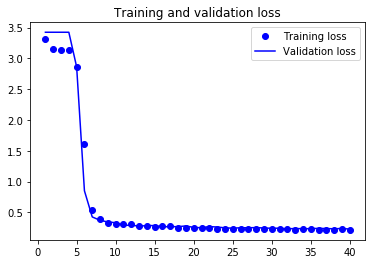

In [11]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

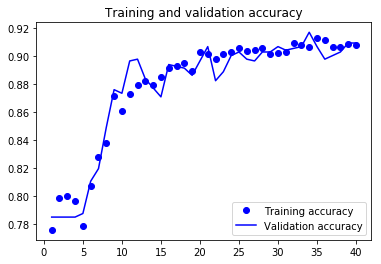

In [12]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

It can be observed that after the fifth epoc the validation loss starts to decrease dramatically. Also the training curves are closely tracking the validation curves.

Finally lets display the acccuracy, precision, recall, and fscore.

In [14]:
model.load_weights('models/ffn.hdf5')

loss, accuracy, precision, recall, fbeta = model.evaluate(x_test, y_test, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))
print("Precision = {:.2f}".format(precision))
print("Recall= {:.2f}".format(recall))
print("Fbeta = {:.2f}".format(fbeta))

704/782 [==========================>...] - ETA: 0s
Accuracy = 0.91
Precision = 0.92
Recall= 0.96
Fbeta = 0.94


Even if the neural network implemented was extremly simple, surprisingly we are getting some incredible results.